In [1]:
import io
import zipfile
import pandas
import warnings
import os
import yaml
import re
import plotnine
from plotnine import *
plotnine.options.figure_size = (12, 8)
warnings.simplefilter(action='ignore')
import cashew
print(cashew.__git_version__)
from cashew import archive_extraction as ae
from cashew import linear_regression as lr

directory = 'expfile_influence/3/'
archives = [os.path.join(directory, f) for f in os.listdir(directory)]
archives

c0a430e3a498fc690b6244ca9909444040c28128


['expfile_influence/3/grenoble_2020-12-03_1965514.zip',
 'expfile_influence/3/grenoble_2020-12-04_1965535.zip',
 'expfile_influence/3/grenoble_2020-12-04_1965524.zip',
 'expfile_influence/3/grenoble_2020-12-03_1965513.zip',
 'expfile_influence/3/grenoble_2020-12-04_1965527.zip',
 'expfile_influence/3/grenoble_2020-12-03_1965508.zip',
 'expfile_influence/3/grenoble_2020-12-03_1965510.zip',
 'expfile_influence/3/grenoble_2020-12-03_1965507.zip',
 'expfile_influence/3/grenoble_2020-12-03_1965515.zip',
 'expfile_influence/3/grenoble_2020-12-04_1965530.zip',
 'expfile_influence/3/grenoble_2020-12-04_1965517.zip',
 'expfile_influence/3/grenoble_2020-12-03_1965511.zip',
 'expfile_influence/3/grenoble_2020-12-04_1965526.zip',
 'expfile_influence/3/grenoble_2020-12-04_1965523.zip',
 'expfile_influence/3/grenoble_2020-12-04_1965531.zip',
 'expfile_influence/3/grenoble_2020-12-04_1965534.zip',
 'expfile_influence/3/grenoble_2020-12-04_1965525.zip',
 'expfile_influence/3/grenoble_2020-12-03_196550

In [2]:
dataframes = []
for archi in archives:
    df = ae.read_performance(archi)
    expfile = ae.read_yaml(archi, 'info.yaml')['expfile'][0]
    df['expfile'] = expfile
    exp = expfile.split('_')
    assert len(exp) == 3
    df['exp_kind'] = exp[1]
    dataframes.append(df)

df = pandas.concat(dataframes)
print(len(df))
df.head()

435520


,function,m,n,k,timestamp,duration,core,node,cluster,jobid,cpu,start_time,index,expfile_hash,expfile,exp_kind
0,dgemm,4092,4441,128,68.476076,0.169125,0,5,dahu,1965514,0,1607031268,0,59e1850c50f67c5ac487abb7fd28e9746c8cff7f637d36...,exp_128_22.csv,128
1,dgemm,3861,5413,128,68.645226,0.196977,0,5,dahu,1965514,0,1607031268,1,59e1850c50f67c5ac487abb7fd28e9746c8cff7f637d36...,exp_128_22.csv,128
2,dgemm,6009,13013,128,68.842213,0.724227,0,5,dahu,1965514,0,1607031268,2,59e1850c50f67c5ac487abb7fd28e9746c8cff7f637d36...,exp_128_22.csv,128
3,dgemm,2360,6640,128,69.566449,0.148721,0,5,dahu,1965514,0,1607031268,3,59e1850c50f67c5ac487abb7fd28e9746c8cff7f637d36...,exp_128_22.csv,128
4,dgemm,4808,2154,128,69.715178,0.097832,0,5,dahu,1965514,0,1607031268,4,59e1850c50f67c5ac487abb7fd28e9746c8cff7f637d36...,exp_128_22.csv,128


## Distribution of the sizes

In [3]:
mn = pandas.Series((df['m'] * df['n']).unique())
equi_line = []
for i, med_mn in enumerate(mn.quantile([0.25, 0.5, 0.75])):
    med_mn = int(med_mn)
    tmp = pandas.DataFrame({'m':range(1, med_mn, med_mn//10000)})
    tmp['n'] = med_mn/tmp['m']
    tmp['group'] = i
    equi_line.append(tmp)
equi_line = pandas.concat(equi_line)
equi_line = equi_line[(equi_line['m'] <= df['m'].max()) & (equi_line['n'] <= df['n'].max())]
equi_line.head()

,m,n,group
1,389,9981.010283,0
2,777,4996.927928,0
3,1165,3332.715021,0
4,1553,2500.072762,0
5,1941,2000.315817,0


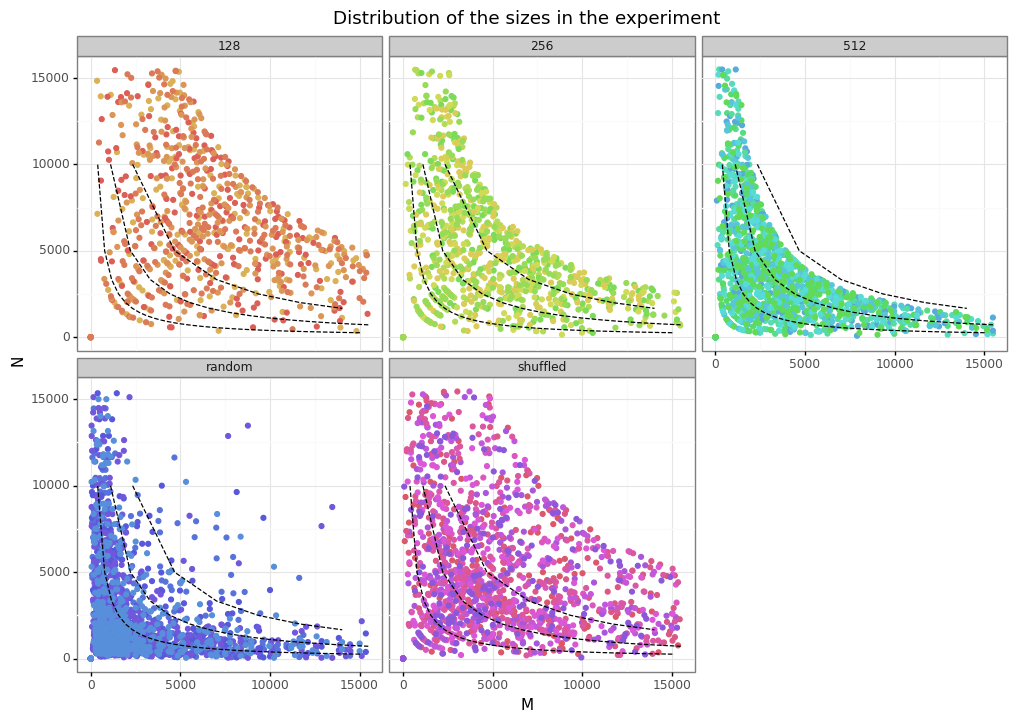

<ggplot: (-9223363262996912489)>


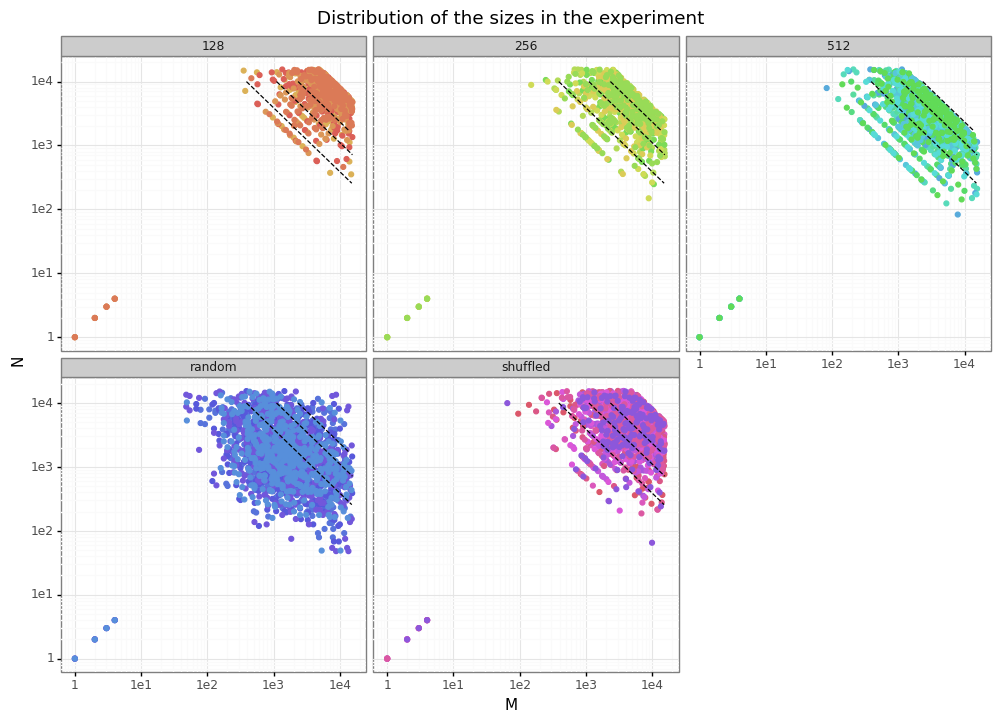

<ggplot: (8773858029853)>


In [4]:
plot = (ggplot(df[['expfile', 'exp_kind', 'm', 'n', 'k']].drop_duplicates())
    + aes(x='m', y='n', color='expfile')
    + geom_point()
    + geom_line(aes(group='group'), data=equi_line, color='black', linetype='dashed')
    + theme_bw()
    + labs(x='M', y='N')
    + ggtitle('Distribution of the sizes in the experiment')
    + expand_limits(y=0)
    + facet_wrap('exp_kind')
    + theme(legend_position='none')
)
print(plot)
print(plot + scale_x_log10() + scale_y_log10())

## Performance

In [5]:
aggregated_df = pandas.DataFrame(lr.regression(df, lr.compute_dgemm_reg)).set_index('jobid')
names = df[['jobid', 'expfile', 'exp_kind']].drop_duplicates().set_index('jobid')
aggregated_df['expfile'] = names['expfile']
aggregated_df['exp_kind'] = names['exp_kind']
aggregated_df = aggregated_df.reset_index()
aggregated_df.head()

,jobid,intercept,mnk,mn,mk,nk,tvalue_mnk,tvalue_mn,tvalue_mk,tvalue_nk,...,tvalue_nk_residual,avg_gflops,function,cluster,node,expfile_hash,cpu,start_time,expfile,exp_kind
0,1965506,0,7.890498e-11,-1.270362e-09,2.292311e-09,2.746849e-09,151.652156,-5.012503,11.786122,14.123168,...,3.558076,25.553097,dgemm,dahu,5,7beb1d14286631a62c20075989951dc103a2a6d3934f84...,0,1607018422,exp_512_24.csv,512
1,1965506,0,7.210205e-11,-1.255431e-09,2.137528e-09,2.291892e-09,124.298922,-4.443197,9.857910,10.569809,...,3.244105,28.059106,dgemm,dahu,5,7beb1d14286631a62c20075989951dc103a2a6d3934f84...,1,1607018422,exp_512_24.csv,512
2,1965506,0,7.963380e-11,-1.241608e-09,2.370912e-09,3.106645e-09,157.029920,-5.026348,12.507012,16.388144,...,4.035191,25.248700,dgemm,dahu,6,7beb1d14286631a62c20075989951dc103a2a6d3934f84...,0,1607018422,exp_512_24.csv,512
3,1965506,0,7.128525e-11,-1.281312e-09,2.131227e-09,2.418234e-09,122.819739,-4.532173,9.823166,11.146023,...,4.031150,28.389738,dgemm,dahu,6,7beb1d14286631a62c20075989951dc103a2a6d3934f84...,1,1607018422,exp_512_24.csv,512
4,1965507,0,7.767360e-11,-2.978642e-10,2.521482e-09,2.963753e-09,168.541892,-2.799809,9.238683,10.859163,...,4.597151,25.666593,dgemm,dahu,5,5127db8868b5c31f05e453390cd3fa2a7473ad4e2110a9...,0,1607019987,exp_256_17.csv,256


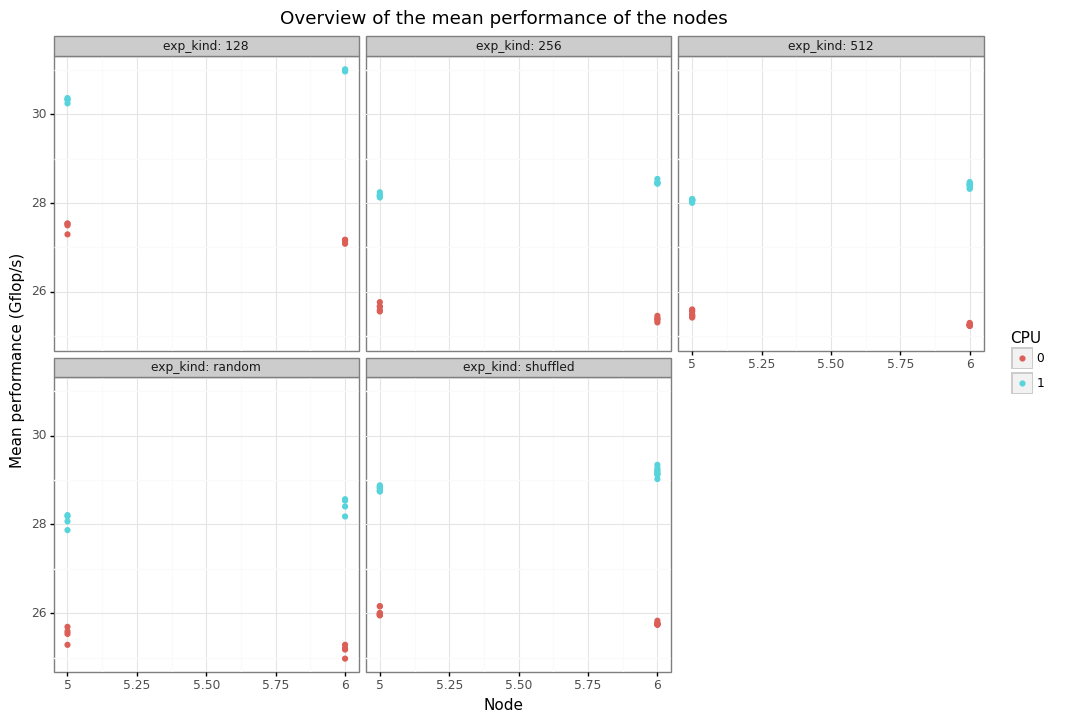

<ggplot: (8773850687166)>

In [6]:
(ggplot(aggregated_df)
    + aes(x='node', y='avg_gflops', color='factor(cpu)')
    + geom_point()
    + theme_bw()
    + facet_wrap('exp_kind', labeller='label_both')
    + labs(x='Node', y='Mean performance (Gflop/s)', color='CPU')
    + ggtitle('Overview of the mean performance of the nodes')
   # + expand_limits(y=0)
)

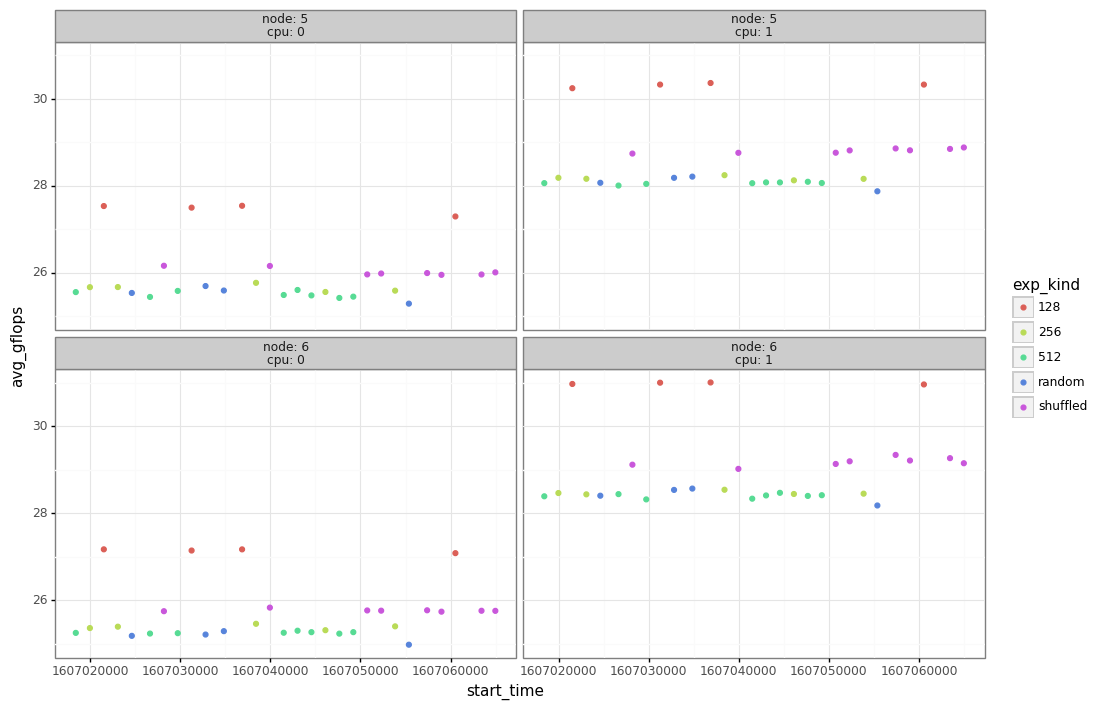

<ggplot: (-9223363262996793512)>


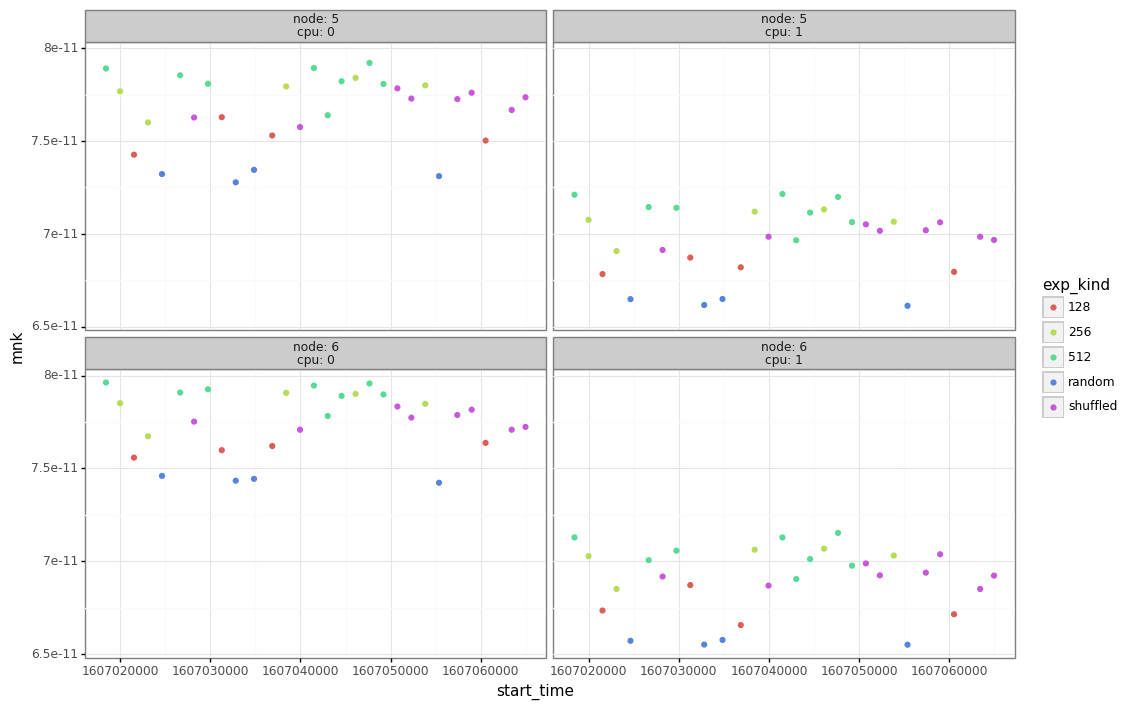

<ggplot: (8773814698027)>


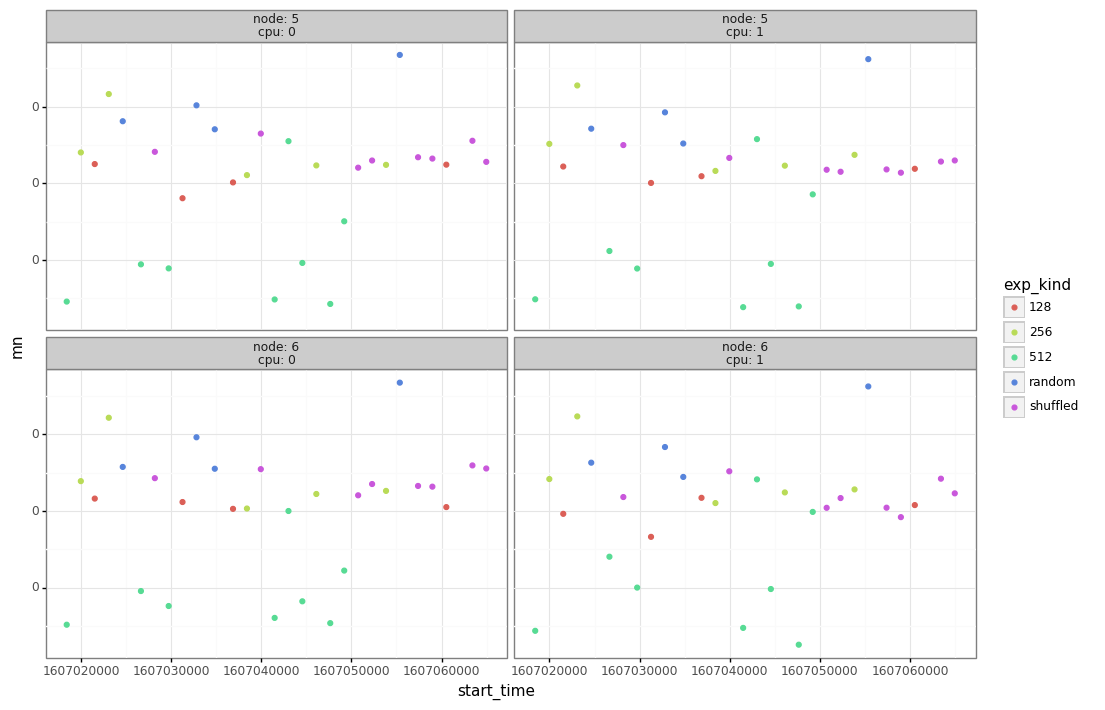

<ggplot: (-9223363263040218652)>


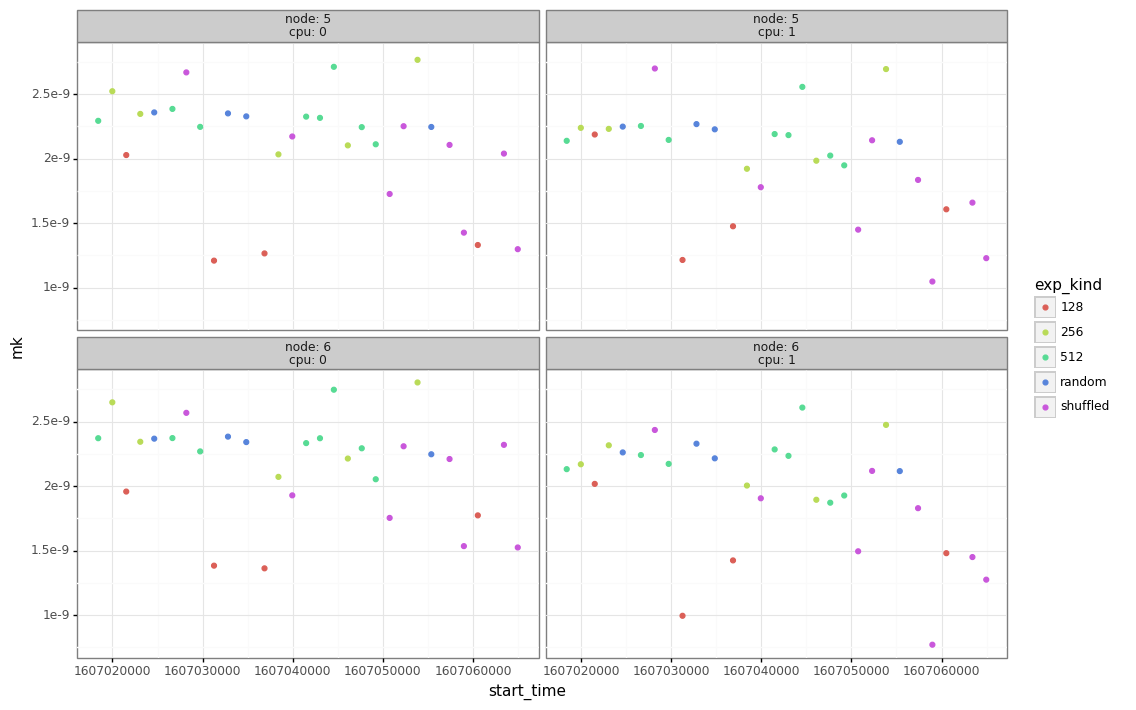

<ggplot: (8773858223231)>


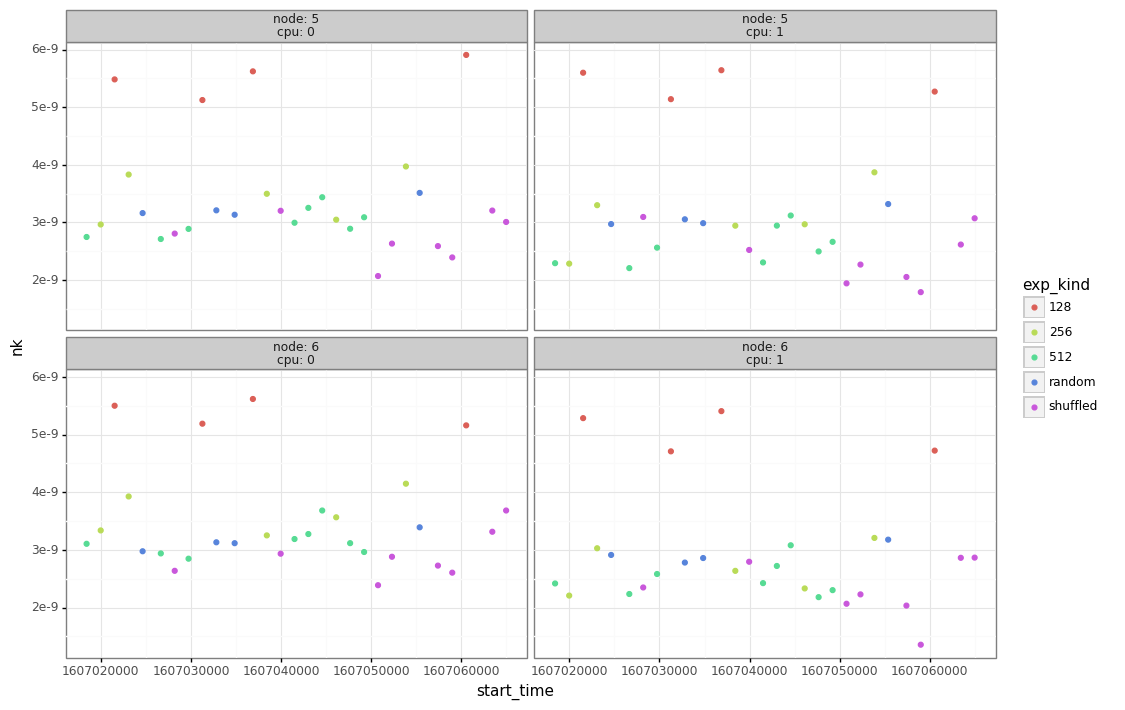

<ggplot: (8773852990114)>


In [7]:
for col in ['avg_gflops', 'mnk', 'mn', 'mk', 'nk']:
    print(ggplot(aggregated_df)
        + aes(x='start_time', y=col, color='exp_kind')
        + geom_point()
        + theme_bw()
        + facet_wrap(['node', 'cpu'], labeller='label_both')
    )

In [8]:
first_exp = set(df.groupby('exp_kind')[['jobid']].min()['jobid'])
df[(df['jobid'].isin(first_exp)) & (df['node'] == 5)][['jobid', 'expfile', 'm', 'n', 'k', 'node', 'cpu', 'duration']].to_csv('/tmp/dgemm_raw_data.csv', index=False)

In [9]:
df[['expfile', 'm', 'n', 'k']].drop_duplicates().to_csv('/tmp/dgemm_expfile_content.csv', index=False)

In [10]:
aggregated_df.to_csv('/tmp/dgemm_agr_data.csv', index=False)

In [11]:
del df
del aggregated_df

## Monitoring

In [12]:
dataframes = []
for f in archives:
    tmp = ae.read_monitoring(f)
    expfile = ae.read_yaml(f, 'info.yaml')['expfile'][0]
    tmp['expfile'] = expfile
    exp = expfile.split('_')
    assert len(exp) == 3
    tmp['exp_kind'] = exp[1]
    dataframes.append(tmp)
monitoring = pandas.concat(dataframes)
monitoring['date'] = pandas.to_datetime(monitoring['start_time'], unit='s').astype(str)
for date in monitoring['date'].unique():
    monitoring.loc[monitoring['date'] == date, 'real_start_time'] = monitoring[monitoring['date'] == date]['timestamp'].min()
monitoring['start_exp'] -= monitoring['real_start_time']
monitoring['stop_exp'] -= monitoring['real_start_time']
monitoring['timestamp'] -= monitoring['real_start_time']
monitoring['cpu_id'] = monitoring['node'].astype(str) + ':' + monitoring['cpu'].astype(str)
monitoring['in_exp'] = (monitoring['timestamp'] > monitoring['start_exp'] + 60) & (monitoring['timestamp'] < monitoring['stop_exp'] - 60)
monitoring['hostname'] = monitoring['cluster'] + '-' + monitoring['node'].astype(str)
print(len(monitoring))
monitoring.head()

700928


,timestamp,cluster,node,jobid,start_time,expfile_hash,value,cpu,core,kind,start_exp,stop_exp,expfile,exp_kind,date,real_start_time,cpu_id,in_exp,hostname
0,0.058979,dahu,5,1965514,1607031268,59e1850c50f67c5ac487abb7fd28e9746c8cff7f637d36...,2.767529,0,0,frequency,625.018584,869.467972,exp_128_22.csv,128,2020-12-03 21:34:28,1.607035e+09,5:0,False,dahu-5
1,5.062967,dahu,5,1965514,1607031268,59e1850c50f67c5ac487abb7fd28e9746c8cff7f637d36...,2.757788,0,0,frequency,625.018584,869.467972,exp_128_22.csv,128,2020-12-03 21:34:28,1.607035e+09,5:0,False,dahu-5
2,10.068073,dahu,5,1965514,1607031268,59e1850c50f67c5ac487abb7fd28e9746c8cff7f637d36...,3.336877,0,0,frequency,625.018584,869.467972,exp_128_22.csv,128,2020-12-03 21:34:28,1.607035e+09,5:0,False,dahu-5
3,15.073189,dahu,5,1965514,1607031268,59e1850c50f67c5ac487abb7fd28e9746c8cff7f637d36...,3.228442,0,0,frequency,625.018584,869.467972,exp_128_22.csv,128,2020-12-03 21:34:28,1.607035e+09,5:0,False,dahu-5
4,20.078245,dahu,5,1965514,1607031268,59e1850c50f67c5ac487abb7fd28e9746c8cff7f637d36...,1.404656,0,0,frequency,625.018584,869.467972,exp_128_22.csv,128,2020-12-03 21:34:28,1.607035e+09,5:0,False,dahu-5


In [13]:
grouped_mon = monitoring[monitoring.in_exp].groupby(['node', 'cpu', 'cpu_id', 'kind', 'expfile', 'exp_kind', 'real_start_time'])[['value']].mean().reset_index()
grouped_mon

,node,cpu,cpu_id,kind,expfile,exp_kind,real_start_time,value
0,5,0,5:0,frequency,exp_128_01.csv,128,1.607026e+09,2.090869
1,5,0,5:0,frequency,exp_128_08.csv,128,1.607065e+09,2.077797
2,5,0,5:0,frequency,exp_128_21.csv,128,1.607041e+09,2.094058
3,5,0,5:0,frequency,exp_128_22.csv,128,1.607035e+09,2.088443
4,5,0,5:0,frequency,exp_256_13.csv,256,1.607058e+09,1.948725
...,...,...,...,...,...,...,...,...
227,6,1,6:1,temperature,exp_shuffled_07.csv,shuffled,1.607067e+09,65.392500
228,6,1,6:1,temperature,exp_shuffled_10.csv,shuffled,1.607056e+09,65.296875
229,6,1,6:1,temperature,exp_shuffled_20.csv,shuffled,1.607032e+09,65.062500
230,6,1,6:1,temperature,exp_shuffled_22.csv,shuffled,1.607055e+09,65.247500


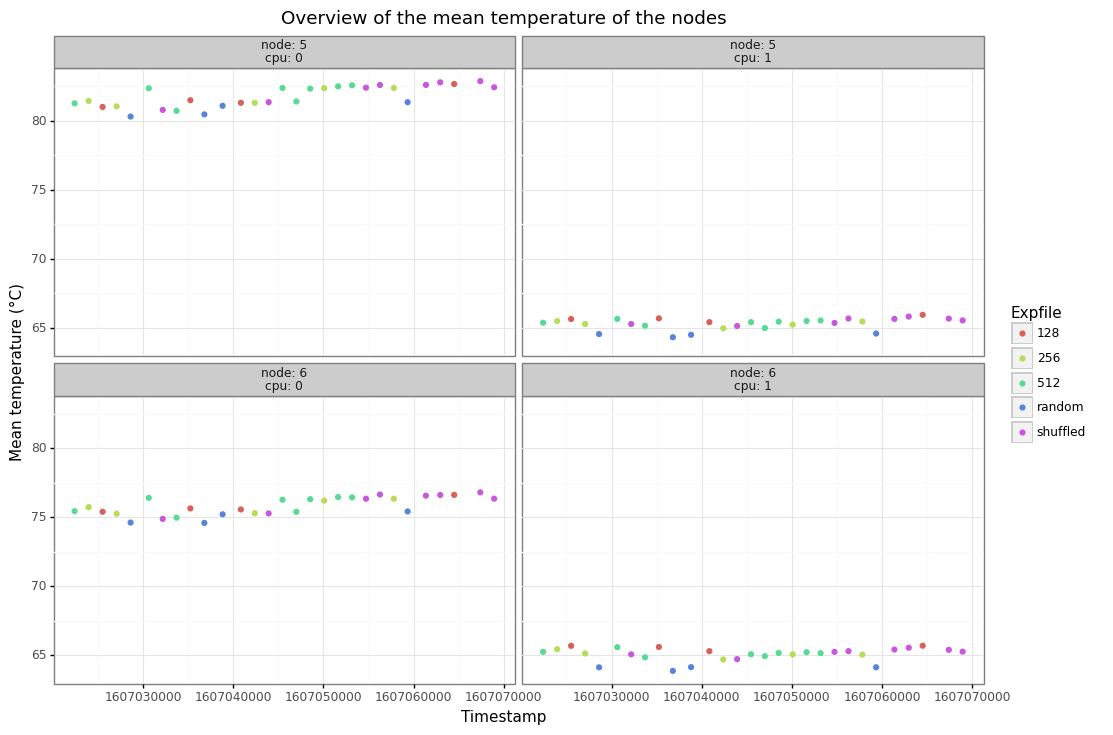

<ggplot: (8773857922568)>

In [14]:
(ggplot(grouped_mon[grouped_mon['kind'] == 'temperature'])
    + aes(x='real_start_time', y='value', color='exp_kind')
    + geom_point()
    + theme_bw()
    + facet_wrap(['node', 'cpu'], labeller='label_both')
    + labs(x='Timestamp', y='Mean temperature (°C)', color='Expfile')
    + ggtitle('Overview of the mean temperature of the nodes')
)

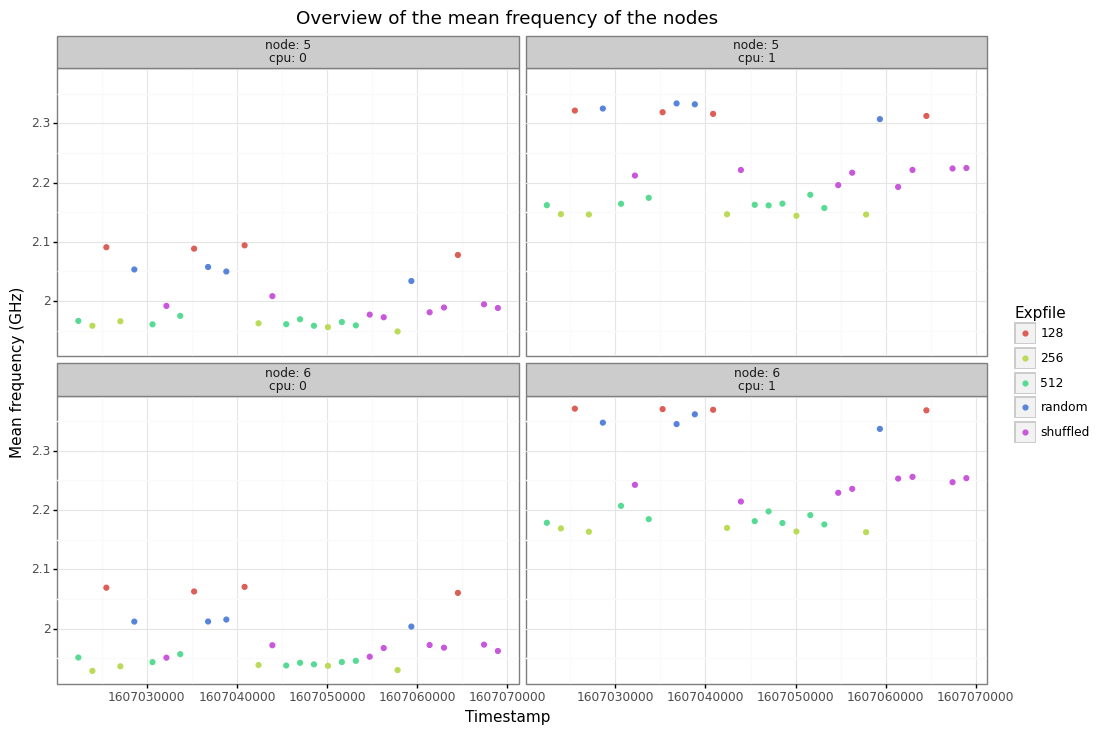

<ggplot: (8773857951019)>

In [15]:
(ggplot(grouped_mon[grouped_mon['kind'] == 'frequency'])
    + aes(x='real_start_time', y='value', color='exp_kind')
    + geom_point()
    + theme_bw()
    + facet_wrap(['node', 'cpu'], labeller='label_both')
    + labs(x='Timestamp', y='Mean frequency (GHz)', color='Expfile')
    + ggtitle('Overview of the mean frequency of the nodes')
)

In [16]:
import re
reg = re.compile('power_package-(?P<cpu_id>[0-9]+)(_(?P<sub_group>[a-z]+))?')
reg.fullmatch('power_package-1').groupdict()

{'cpu_id': '1', 'sub_group': None}

In [17]:
import numpy
import re

def melt_power(df, idcol):
    reg = re.compile('power_package-(?P<cpu_id>[0-9]+)(_(?P<sub_group>[a-z]+))?')
    result = []
    columns = list(df.columns)
    for col in columns:
        match = reg.fullmatch(col)
        if match is None:
            continue
        tmp = df[idcol].copy()
        tmp['value'] = df[col]
        tmp['CPU'] = int(match.groupdict()['cpu_id'])
        tmp['subgroup'] = str(match.groupdict()['sub_group'])
        result.append(tmp)
    return pandas.concat(result)

def read_monitoring_power(archive_name, columns=None):
    '''
    Read the durations of a BLAS calibration in an archive.
    '''
    csv_name = 'monitoring.csv'
    df = ae.read_archive_csv_enhanced(archive_name, csv_name, columns=columns)
    df['timestamp'] = pandas.to_datetime(df['timestamp'])
    columns = ['timestamp', 'cluster', 'node', 'jobid', 'start_time', 'expfile_hash']
    power = melt_power(df, columns)
    power['timestamp'] = power['timestamp'].astype(numpy.int64) / 10 ** 9
    power['timestamp'] = power['timestamp'] - power['timestamp'].min()
    return power

dataframes = []
for f in archives:
    tmp = read_monitoring_power(f)
    expfile = ae.read_yaml(f, 'info.yaml')['expfile'][0]
    tmp['expfile'] = expfile
    exp = expfile.split('_')
    assert len(exp) == 3
    tmp['exp_kind'] = exp[1]
    dataframes.append(tmp)
power = pandas.concat(dataframes)

for jobid in power['jobid'].unique():
    for col in ['start_exp', 'stop_exp']:
        val = monitoring[monitoring['jobid'] == jobid][col].unique()
        assert len(val) == 1
        power.loc[power['jobid'] == jobid, col] = val[0]
power.head()

,timestamp,cluster,node,jobid,start_time,expfile_hash,value,CPU,subgroup,expfile,exp_kind,start_exp,stop_exp
0,0.058979,dahu,5,1965514,1607031268,59e1850c50f67c5ac487abb7fd28e9746c8cff7f637d36...,52.076956,1,None,exp_128_22.csv,128,625.018584,869.467972
1,5.062967,dahu,5,1965514,1607031268,59e1850c50f67c5ac487abb7fd28e9746c8cff7f637d36...,122.349541,1,None,exp_128_22.csv,128,625.018584,869.467972
2,10.068073,dahu,5,1965514,1607031268,59e1850c50f67c5ac487abb7fd28e9746c8cff7f637d36...,57.698700,1,None,exp_128_22.csv,128,625.018584,869.467972
3,15.073189,dahu,5,1965514,1607031268,59e1850c50f67c5ac487abb7fd28e9746c8cff7f637d36...,46.053699,1,None,exp_128_22.csv,128,625.018584,869.467972
4,20.078245,dahu,5,1965514,1607031268,59e1850c50f67c5ac487abb7fd28e9746c8cff7f637d36...,39.672806,1,None,exp_128_22.csv,128,625.018584,869.467972


In [18]:
grouped_power = power[(power['timestamp'] > power['start_exp']+60) & (power['timestamp'] < power['stop_exp']-60)].groupby(['subgroup', 'node', 'CPU', 'expfile', 'exp_kind', 'start_time'])[['value']].mean().reset_index()
grouped_power

,subgroup,node,CPU,expfile,exp_kind,start_time,value
0,None,5,0,exp_128_01.csv,128,1607021532,124.639089
1,None,5,0,exp_128_08.csv,128,1607060530,124.639872
2,None,5,0,exp_128_21.csv,128,1607036868,124.639887
3,None,5,0,exp_128_22.csv,128,1607031268,124.639069
4,None,5,0,exp_256_13.csv,256,1607053843,124.636168
...,...,...,...,...,...,...,...
227,dram,6,1,exp_shuffled_07.csv,shuffled,1607063426,12.262524
228,dram,6,1,exp_shuffled_10.csv,shuffled,1607052297,12.042765
229,dram,6,1,exp_shuffled_20.csv,shuffled,1607028197,12.057956
230,dram,6,1,exp_shuffled_22.csv,shuffled,1607050750,12.134551


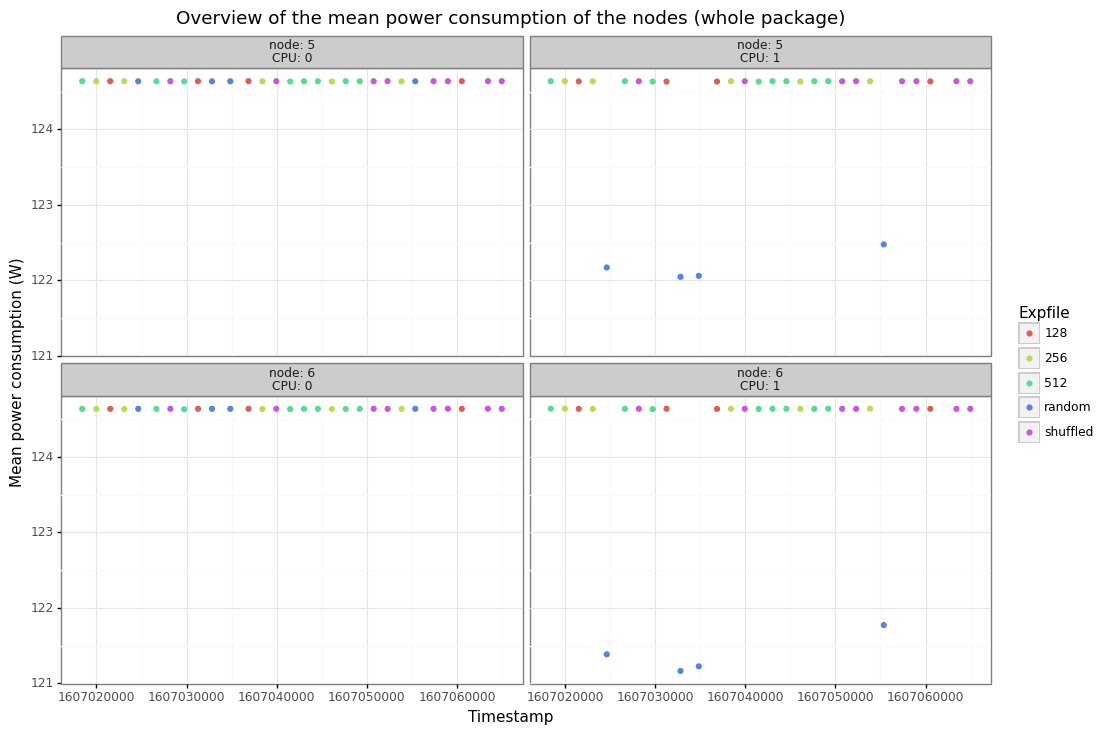

<ggplot: (-9223363262996787312)>

In [19]:
(ggplot(grouped_power[grouped_power['subgroup'] == 'None'])
    + aes(x='start_time', y='value', color='exp_kind')
    + geom_point()
    + theme_bw()
    + facet_wrap(['node', 'CPU'], labeller='label_both')
    + labs(x='Timestamp', y='Mean power consumption (W)', color='Expfile')
    + ggtitle('Overview of the mean power consumption of the nodes (whole package)')
)

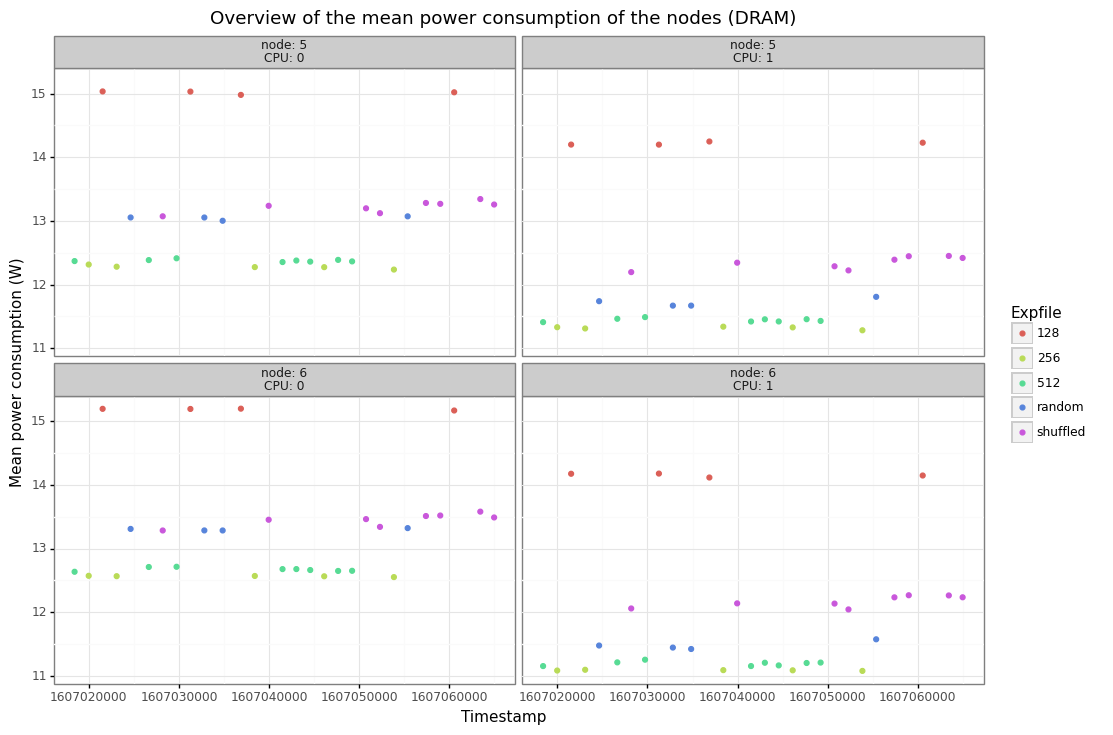

<ggplot: (-9223363263044901916)>

In [20]:
(ggplot(grouped_power[grouped_power['subgroup'] == 'dram'])
    + aes(x='start_time', y='value', color='exp_kind')
    + geom_point()
    + theme_bw()
    + facet_wrap(['node', 'CPU'], labeller='label_both')
    + labs(x='Timestamp', y='Mean power consumption (W)', color='Expfile')
    + ggtitle('Overview of the mean power consumption of the nodes (DRAM)')
)

In [21]:
tmp_mon = grouped_mon.rename(columns={'real_start_time': 'start_time'})
tmp_pow = grouped_power.rename(columns={'CPU': 'cpu'})
tmp_pow['kind'] = 'power'
tmp_pow.loc[tmp_pow['subgroup'] == 'None', 'subgroup'] = 'package'
dump = pandas.concat([tmp_mon, tmp_pow])[['node', 'cpu', 'kind', 'expfile', 'exp_kind', 'start_time', 'value', 'subgroup']]
dump.to_csv('/tmp/dgemm_agr_monitoring.csv', index=False)
dump

,node,cpu,kind,expfile,exp_kind,start_time,value,subgroup
0,5,0,frequency,exp_128_01.csv,128,1.607026e+09,2.090869,NaN
1,5,0,frequency,exp_128_08.csv,128,1.607065e+09,2.077797,NaN
2,5,0,frequency,exp_128_21.csv,128,1.607041e+09,2.094058,NaN
3,5,0,frequency,exp_128_22.csv,128,1.607035e+09,2.088443,NaN
4,5,0,frequency,exp_256_13.csv,256,1.607058e+09,1.948725,NaN
...,...,...,...,...,...,...,...,...
227,6,1,power,exp_shuffled_07.csv,shuffled,1.607063e+09,12.262524,dram
228,6,1,power,exp_shuffled_10.csv,shuffled,1.607052e+09,12.042765,dram
229,6,1,power,exp_shuffled_20.csv,shuffled,1.607028e+09,12.057956,dram
230,6,1,power,exp_shuffled_22.csv,shuffled,1.607051e+09,12.134551,dram


In [22]:
tmp_mon = monitoring.copy()
tmp_pow = power.rename(columns={'CPU': 'cpu'})
tmp_pow['kind'] = 'power'
tmp_pow.loc[tmp_pow['subgroup'] == 'None', 'subgroup'] = 'package'
dump = pandas.concat([tmp_mon, tmp_pow])[['jobid', 'node', 'cpu', 'kind', 'expfile', 'exp_kind', 'start_time', 'value', 'subgroup', 'timestamp']]
dump = dump[(dump['jobid'].isin(first_exp)) & (dump['node'] == 5)]
dump.to_csv('/tmp/dgemm_raw_monitoring.csv', index=False)
dump

,jobid,node,cpu,kind,expfile,exp_kind,start_time,value,subgroup,timestamp
0,1965508,5,0,frequency,exp_128_01.csv,128,1607021532,3.324700,NaN,0.000000
1,1965508,5,0,frequency,exp_128_01.csv,128,1607021532,2.471191,NaN,5.004981
2,1965508,5,0,frequency,exp_128_01.csv,128,1607021532,1.000140,NaN,10.010064
3,1965508,5,0,frequency,exp_128_01.csv,128,1607021532,2.775091,NaN,15.014594
4,1965508,5,0,frequency,exp_128_01.csv,128,1607021532,2.654479,NaN,20.018612
...,...,...,...,...,...,...,...,...,...,...
170,1965512,5,0,power,exp_shuffled_20.csv,shuffled,1607028197,12.596735,dram,850.724620
171,1965512,5,0,power,exp_shuffled_20.csv,shuffled,1607028197,12.255105,dram,855.729622
172,1965512,5,0,power,exp_shuffled_20.csv,shuffled,1607028197,8.373322,dram,860.734624
173,1965512,5,0,power,exp_shuffled_20.csv,shuffled,1607028197,8.365278,dram,865.739624
